In [ ]:
%%shell
pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.2 MB/s eta 0:00:00


In [ ]:
import re
import requests
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from unidecode import unidecode
from dataclasses import dataclass
from typing import List, Type, Dict
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
from collections import Counter

nltk_pkgs = ["punkt", "stopwords"]

for pkg in nltk_pkgs:
    nltk.download(pkg)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Carga de Datos

In [ ]:
r = requests.get("https://es.wikipedia.org/wiki/Noam_Chomsky")
assert r.status_code == 200
raw_text = r.text
text = (
    BeautifulSoup(raw_text)
    .find(id="bodyContent")
    .get_text()
)
print(text)





De Wikipedia, la enciclopedia libre


Noam Chomsky
Noam Chomsky en 2017Información personalNombre de nacimiento
Avram Noam Chomsky Nacimiento
7 de diciembre de 1928  (94 años)Filadelfia, Pensilvania, Estados UnidosNacionalidad
EstadounidenseReligión
AteísmoFamiliaPadre
William Chomsky Cónyuge
Carol Chomsky (1949-2008)Valeria Wasserman Chomsky (desde 2014) EducaciónEducado en
Instituto Tecnológico de MassachusettsOak Lane Day SchoolCentral High School (hasta 1945)Universidad de Pensilvania (B.A.; 1945-1949)Universidad de Pensilvania (M.A.; 1949-1951)Universidad de Harvard (Lingüística; 1951-1955) Alumno de
Zellig HarrisNelson GoodmanRoman Jakobson Información profesionalOcupación
Filósofo, lingüista, escritor político, profesor universitario, psicólogo, antropólogo, activista por los derechos humanos, educador, crítico de medios, escritor, publicista, informático teórico, historiador y antisionista Área
Lingüística, filosofía del lenguaje, psicología, gramática generativa, teoría de

In [ ]:
corpus = sent_tokenize(text, language="spanish")

In [ ]:
len(corpus)

335

In [ ]:
class Perro:
    def __init__(self, name: str):
        self.name = name

    def make_sound(self) -> str:
        return f"{self.name}: Guau!"

In [ ]:
firulais = Perro(name="firulais")
print(firulais.make_sound())

firulais: Guau!


In [ ]:
@dataclass
class LenRange:
    min_len: int
    max_len: int

@dataclass
class PreprocessConfig:
    language: str
    stopwords: List[str]
    word_range: LenRange
    sent_range: LenRange
    patterns: List[re.Pattern]

class Step:
    def __init__(self, config: PreprocessConfig):
        self.config = config

    def forward(self, text:str) -> str:
        ...

class LowerStep(Step):
    def forward(self, text: str) -> str:
        return text.lower()

class WordTokenizeStep(Step):
    def forward(self, text: str) -> str:
        tokens = word_tokenize(text, language=self.config.language)
        return " ".join(tokens)

class UnidecodeStep(Step):
    def forward(self, text: str) -> str:
        return unidecode(text)

class StopwordsStep(Step):
    def forward(self, text: str) -> str:
        tokens = text.split(" ")
        filtered_tokens = filter(
            lambda token: token not in self.config.stopwords,
            tokens
            )
        return " ".join(filtered_tokens)

class LenFilterStep(Step):
    def forward(self, text: str) -> str:
        tokens = text.split(" ")
        filtered_tokens = filter(
            lambda token: (
                len(token) >= self.config.word_range.min_len and
                len(token) <= self.config.word_range.max_len
            ),
            tokens
        )
        return " ".join(filtered_tokens)

class RegexSubStep(Step):
    def forward(self, text: str) -> str:
        for pat in self.config.patterns:
            text = re.sub(pat, " ", text)
        return text

class StripStep(Step):
    def forward(self, text: str) -> str:
        return text.strip()

class SentLenStep(Step):
    def forward(self, text: str) -> str:
        tokens = text.split(" ")
        if (
            len(tokens) < self.config.sent_range.min_len or
            len(tokens) > self.config.sent_range.max_len
            ):
            text = ""
        return text

class Preprocessor:
    def __init__(
        self,
        steps: List[Type[Step]],
        config: PreprocessConfig
        ):
        self.steps = steps
        self.config = config

    def preprocess(self, text: str) -> str:
        for step_type in self.steps:
            step = step_type(self.config)
            text = step.forward(text)
        return text

In [ ]:
sw = stopwords.words("spanish")
config = PreprocessConfig(
    language="spanish",
    stopwords=sw,
    word_range=LenRange(min_len=3, max_len=10),
    sent_range=LenRange(min_len=3, max_len=15),
    patterns=[
        re.compile(r"[^a-z ]"),
        re.compile(r"\s+")
    ]
)
preprocessor = Preprocessor(
    steps=[
        LowerStep,
        WordTokenizeStep,
        UnidecodeStep,
        StopwordsStep,
        RegexSubStep,
        LenFilterStep,
        StripStep,
        SentLenStep
        ],
    config=config
)

In [ ]:
preprocessor.preprocess(corpus[0])

''

In [ ]:
prep_corpus = list(filter(
    lambda text: len(text) != 0,
    map(preprocessor.preprocess, corpus)
    ))

In [ ]:
prep_corpus

['profesor emerito instituto mit figuras mas destacadas siglo gracias trabajos teoria ciencia cognitiva',
 'tambien reconocido activismo politico fuerte critica politica exterior unidos',
 'considera socialista libertario',
 'new york times senalado mas importante pensadores',
 'propuso gramatica generativa disciplina situo sintaxis centro',
 'paradigma cambiaron programas metodos estudio lenguaje',
 'teoria individual lenguaje intenta explicar principios mas profundos mismo',
 'opuso dureza empirismo filosofico cientifico favor cartesiano',
 'todas ideas chocaban ciencias humanas concito multiples adhesiones criticas polemicas acabado autores mas citados',
 'enfoque estudio lenguaje influido filosofia lenguaje mente ver harman fodor',
 'jerarquia chomsky lenguajes formales gran teoria',
 'tambien conocido activismo politico criticas politica exterior unidos paises israel',
 'chomsky desvincula actividad cientifica activismo politico describe mismo miembro sindicato iww',
 'chomsky fig

In [ ]:
df = (
    pd.DataFrame(
        {"corpus": corpus}
    )
    .assign(prep_corpus = lambda df: df.corpus.apply(preprocessor.preprocess))
    .assign(prep_corpus = lambda df: df.prep_corpus.apply(
        lambda text: text if len(text) else np.nan
    ))
    .dropna()
)
df

,corpus,prep_corpus
3,Es profesor emérito de lingüística en el Insti...,profesor emerito instituto mit figuras mas des...
4,También es reconocido por su activismo polític...,tambien reconocido activismo politico fuerte c...
5,Se le considera de pensamiento socialista libe...,considera socialista libertario
6,[2]​ El New York Times lo ha señalado como «el...,new york times senalado mas importante pensadores
7,"[3]​\nPropuso la gramática generativa, discipl...",propuso gramatica generativa disciplina situo ...
...,...,...
328,Archivado desde el original el 13 de julio de ...,archivado original julio
330,Enlaces externos[editar]\n Wikimedia Commons a...,enlaces externos editar wikimedia commons albe...
331,Wikiquote alberga frases célebres de o sobre N...,wikiquote alberga frases celebres noam chomsky
332,Artículos de Noam Chomsky en The Guardian.,articulos noam chomsky the guardian


# Resumen Extractivo

`text → extraccion de oraciones → preprocessar → tfidf → calcular scores → ordenar`

In [ ]:
vect = TfidfVectorizer(norm=None, sublinear_tf=True).fit(df.prep_corpus)

In [ ]:
tfidf = vect.transform(df.prep_corpus)

$$
\text{score}_i = || \text{tfidf(d_i)} || \\
|| \mathbf{x} || = \sqrt{\sum_{i}^m x_i ^ 2}
$$

In [ ]:
scores = np.linalg.norm(tfidf.toarray(), axis=1)
scores.shape

(208,)

In [ ]:
df_scores = df.assign(scores=scores)
df_scores

,corpus,prep_corpus,scores
3,Es profesor emérito de lingüística en el Insti...,profesor emerito instituto mit figuras mas des...,18.267271
4,También es reconocido por su activismo polític...,tambien reconocido activismo politico fuerte c...,13.679821
5,Se le considera de pensamiento socialista libe...,considera socialista libertario,9.044901
6,[2]​ El New York Times lo ha señalado como «el...,new york times senalado mas importante pensadores,13.192908
7,"[3]​\nPropuso la gramática generativa, discipl...",propuso gramatica generativa disciplina situo ...,13.709239
...,...,...,...
328,Archivado desde el original el 13 de julio de ...,archivado original julio,8.301330
330,Enlaces externos[editar]\n Wikimedia Commons a...,enlaces externos editar wikimedia commons albe...,15.859436
331,Wikiquote alberga frases célebres de o sobre N...,wikiquote alberga frases celebres noam chomsky,11.868864
332,Artículos de Noam Chomsky en The Guardian.,articulos noam chomsky the guardian,9.587650


In [ ]:
print("\n".join(
    df
    .assign(scores=scores)
    .sort_values(by="scores", ascending=False)
    .head(6)
    .corpus
    .reset_index()
    .sort_values(by="index")
    .corpus
    .to_list()
)
)

A los niños se les supone un conocimiento innato de la gramática elemental común a todas las lenguas humanas (lo que supone que toda lengua existente es una clase de restricción).
La estructura-S señala acciones transformacionales o de parámetro, no solamente de principio como en la estructura-P. Un ejemplo es la operación muévase α, en la que un elemento se mueve en la oración a otra posición.
Su denuncia de la política exterior de Estados Unidos, de las deficiencias democráticas de su maquinaria política, y de los engaños de los grandes medios de comunicación en este país, supone poner en duda tres de los pilares del nacionalismo estadounidense.
[19]​
En cuanto a España, en 2009 firmó un manifiesto de apoyo a la candidatura a las elecciones europeas de la formación política Izquierda Anticapitalista,[20]​ y en 2014 en apoyo de la formación política Podemos.
The Reality Club: Beyond Belief[24]​




La ciencia estudia lo que está al margen de la comprensión, y lo que al margen de la co

# Lexicos

In [ ]:
%%shell
cp /content/drive/MyDrive/NRC-Emotion-Lexicon.zip file.zip
unzip file.zip

Archive:  file.zip
   creating: NRC-Emotion-Lexicon/
  inflating: NRC-Emotion-Lexicon/Paper-Practical-Ethical-Considerations-Lexicons.pdf  
  inflating: __MACOSX/NRC-Emotion-Lexicon/._Paper-Practical-Ethical-Considerations-Lexicons.pdf  
  inflating: NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-ForVariousLanguages.txt  
  inflating: NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt  
  inflating: __MACOSX/NRC-Emotion-Lexicon/._NRC-Emotion-Lexicon-Wordlevel-v0.92.txt  
  inflating: NRC-Emotion-Lexicon/Paper1_NRC_Emotion_Lexicon.pdf  
  inflating: __MACOSX/NRC-Emotion-Lexicon/._Paper1_NRC_Emotion_Lexicon.pdf  
  inflating: NRC-Emotion-Lexicon/README.txt  
  inflating: NRC-Emotion-Lexicon/Paper-Ethics-Sheet-Emotion-Recognition.pdf  
  inflating: __MACOSX/NRC-Emotion-Lexicon/._Paper-Ethics-Sheet-Emotion-Recognition.pdf  
  inflating: NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Senselevel-v0.92.txt  
  inflating: __MACOSX/NRC-Emotion-Lexicon/._NRC-Emotion-Lexicon-Senselevel-v0.92.txt  
   

In [ ]:
df = pd.read_csv(
    "/content/NRC-Emotion-Lexicon/OneFilePerLanguage/Spanish-NRC-EmoLex.txt",
    sep="\t"
    )

In [ ]:
df

,English Word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,Spanish Word
0,aback,0,0,0,0,0,0,0,0,0,0,detrás
1,abacus,0,0,0,0,0,0,0,0,0,1,ábaco
2,abandon,0,0,0,1,0,1,0,1,0,0,abandonar
3,abandoned,1,0,0,1,0,1,0,1,0,0,abandonado
4,abandonment,1,0,0,1,0,1,0,1,1,0,abandono
...,...,...,...,...,...,...,...,...,...,...,...,...
14149,zone,0,0,0,0,0,0,0,0,0,0,zona
14150,zoo,0,0,0,0,0,0,0,0,0,0,zoo
14151,zoological,0,0,0,0,0,0,0,0,0,0,zoológico
14152,zoology,0,0,0,0,0,0,0,0,0,0,zoología


In [ ]:
emotions = (
    df
    .filter(regex=re.compile(r"^[a-z]+$"))
    .columns
    .to_list()
)
emotions = list(filter(
    lambda emotion: emotion not in ["positive", "negative"],
    emotions
    ))
emotions

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'sadness',
 'surprise',
 'trust']

In [ ]:
df.columns

Index(['English Word', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'negative', 'positive', 'sadness', 'surprise', 'trust', 'Spanish Word'],
      dtype='object')

In [ ]:
emotions_vocab = {}
for emotion in emotions:
    words = (
        df
        .query(f"{emotion} == 1")
        .loc[:, "Spanish Word"]
        .to_list()
    )
    emotions_vocab.update({emotion: words})

In [ ]:
emotions_vocab.keys()

dict_keys(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust'])

In [ ]:
def convert2emotion(text: str, emotions_vocab: Dict[str, List[str]]) -> str:
    emotion_tokens = []
    for token in text.split(" "):
        for emotion, words in emotions_vocab.items():
            if token in words:
                emotion_tokens.append(emotion)
    return " ".join(emotion_tokens)

In [ ]:
sample_text = """
La depresión es un trastorno mental caracterizado fundamentalmente por un bajo estado de ánimo y sentimientos de tristeza, asociados a alteraciones del comportamiento, del grado de actividad y del pensamiento.
Supone una de las patologías más frecuentes en Atención Primaria y es la primera causa de atención psiquiátrica y de discapacidad derivada de problemas mentales.
Aparece con más frecuencia en mujeres y en personas menores de 45 años.
El tratamiento con psicofármacos y/o psicoterapia, consiguen, en la mayoría de los casos, aliviar parcialmente o en su totalidad los síntomas. Una vez se han superado los síntomas de la depresión, convendrá seguir bajo tratamiento antidepresivo el tiempo necesario para evitar posibles recaídas. En algunos casos, el tratamiento deberá prolongarse de por vida.
Los síntomas nucleares de la depresión son la tristeza patológica, la pérdida de interés y de la capacidad de disfrutar y una disminución de la vitalidad que limita el nivel de actividad y produce un cansancio exagerado, que aparece incluso después de realizar pequeños esfuerzos.
Además, pueden aparecer otros síntomas, como los sentimientos de culpa o de incapacidad, la irritabilidad, el pesimismo ante el futuro, las ideas de muerte o de suicidio, la pérdida de confianza en uno mismo o en los demás, la disminución de la concentración y la memoria, la intranquilidad, los trastornos del sueño y la disminución del apetito y de la libido, entre otros.
La depresión mayor tiene un origen más biológico o endógeno, con un mayor componente genético y menor influencia de factores externos. Puede aparecer de manera recurrente y, en algunos casos, guarda una cierta relación con la estación del año.
En contraposición, existe la depresión reactiva, causada por una mala adaptación a circunstancias ambientales estresantes.
La distimia, antiguamente conocida como neurosis depresiva, que se caracteriza por un cuadro depresivo de intensidad menor a los anteriores, de evolución crónica (más de dos años), sin periodos asintomáticos y con sentimientos de incapacidad y somatizaciones. Este último tipo de depresión parece guardar una relación más estrecha con la forma de ser y con el estrés prolongado.
Por último, existe un tipo de depresión denominada enmascarada, que en vez de manifestarse con los síntomas ya referidos, aparece como molestias orgánicas -somatizaciones- o cambios en la conducta.
"""
sample_text = """
Cuando un sueño se te muera
O entre en coma una ilusión
No lo entierres ni lo llores, resucítalo
Y jamás des por perdida
La partida, cree en ti
Y aunque duelan, las heridas curarán
Hoy el día ha venido a buscarte
Y la vida huele a besos de jazmín
La mañana está recién bañada
El sol la ha traído a invitarte a vivir
Y verás que tú puedes volar
Y que todo lo consigues
Y verás que no existe el dolor
Hoy te toca ser feliz
Si las lágrimas te nublan
La vista y el corazón
Haz un trasvase de agua
Al miedo, escúpelo
Y si crees que en el olvido
Se anestesia un mal de amor
No hay peor remedio
Que la soledad
Deja entrar en tu alma una brisa
Que avente las dudas y alivie tu mal
Que la pena se muera de risa
Cuando un sueño muere
Es porque se ha hecho real
Y verás que tú puedes volar
Y que todo lo consigues
Y verás que no existe el dolor
Hoy te toca ser feliz
Las estrellas en el cielo
Son solo migas de pan
Que nos dejan nuestros sueños
Para encontrar
El camino, y no perdernos
Hacia la tierra de Oz
Donde habita la ilusión
Y verás que tú puedes volar
Y que todo lo consigues
Y verás que no existe el dolor
Hoy te toca ser feliz
Y verás que tú puedes volar
Y que tu cuerpo es el viento
Porque hoy tú vas a sonreír
Hoy te toca ser feliz
"""

In [ ]:
sw = stopwords.words("spanish")
config = PreprocessConfig(
    language="spanish",
    stopwords=sw,
    word_range=LenRange(min_len=3, max_len=10),
    sent_range=LenRange(min_len=3, max_len=1000),
    patterns=[
        re.compile(r"[^a-zñóíáéú ]"),
        re.compile(r"\s+")
    ]
)
preprocessor = Preprocessor(
    steps=[
        LowerStep,
        WordTokenizeStep,
        StopwordsStep,
        RegexSubStep,
        LenFilterStep,
        StripStep,
        SentLenStep
        ],
    config=config
)

In [ ]:
preprocess_text = preprocessor.preprocess(sample_text)

In [ ]:
preprocess_text

'sueño muera coma ilusión entierres llores resucítalo jamás des perdida partida cree aunque duelan heridas curarán hoy día venido buscarte vida huele besos jazmín mañana recién bañada sol traído invitarte vivir verás puedes volar consigues verás existe dolor hoy toca ser feliz lágrimas nublan vista corazón haz trasvase agua miedo escúpelo crees olvido anestesia mal amor peor remedio soledad deja entrar alma brisa avente dudas alivie mal pena muera risa sueño muere hecho real verás puedes volar consigues verás existe dolor hoy toca ser feliz estrellas cielo solo migas pan dejan sueños encontrar camino perdernos hacia tierra habita ilusión verás puedes volar consigues verás existe dolor hoy toca ser feliz verás puedes volar cuerpo viento hoy vas sonreír hoy toca ser feliz'

In [ ]:
text_emotions = convert2emotion(preprocess_text, emotions_vocab)

In [ ]:
print(text_emotions)

fear sadness sadness anticipation anticipation joy surprise trust disgust fear sadness joy joy anger anticipation fear surprise anger fear joy fear sadness fear sadness joy surprise trust trust disgust fear sadness joy disgust fear sadness joy disgust fear sadness joy surprise trust joy


In [ ]:
counts = Counter(text_emotions.split())

(-0.5, 399.5, 199.5, -0.5)

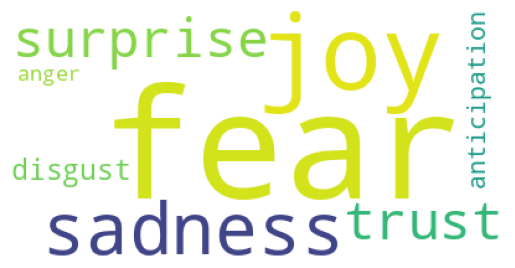

In [ ]:
wc = (
    WordCloud(background_color="white")
    .generate_from_frequencies(counts)
)
fig, ax = plt.subplots()
ax.imshow(wc)
ax.axis("off")

# Autocompletado

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/mindlab-unal/mlds4-datasets/main/u3/movies.csv")

In [ ]:
sw = stopwords.words("english")
config = PreprocessConfig(
    language="english",
    stopwords=sw,
    word_range=LenRange(min_len=1, max_len=10),
    sent_range=LenRange(min_len=3, max_len=1000),
    patterns=[
        re.compile(r"[^a-z ]"),
        re.compile(r"\s+")
    ]
)
preprocessor = Preprocessor(
    steps=[
        LowerStep,
        WordTokenizeStep,
        UnidecodeStep,
        RegexSubStep,
        LenFilterStep,
        StripStep,
        SentLenStep
        ],
    config=config
)

In [ ]:
corpus = (
    df
    .dropna(subset=["overview"])
    .filter(["overview"])
    .assign(prep_text=lambda df: df.overview.apply(preprocessor.preprocess))
)

In [ ]:
corpus

,overview,prep_text
0,"In the 22nd century, a paraplegic Marine is di...",the century paraplegic marine dispatched the m...
1,"Captain Barbossa, long believed to be dead, ha...",captain barbossa long believed dead has come b...
2,A cryptic message from Bond’s past sends him o...,cryptic message from bond past sends him trail...
3,Following the death of District Attorney Harve...,following the death district attorney harvey d...
4,"John Carter is a war-weary, former military ca...",john carter war weary former military captain ...
...,...,...
4798,El Mariachi just wants to play his guitar and ...,mariachi just wants play his guitar and carry ...
4799,A newlywed couple's honeymoon is upended by th...,newlywed couple honeymoon upended the arrivals...
4800,"""Signed, Sealed, Delivered"" introduces a dedic...",signed sealed delivered introduces dedicated q...
4801,When ambitious New York attorney Sam is sent t...,when ambitious new york attorney sam sent shan...


In [ ]:
vect = CountVectorizer(ngram_range=(3, 3)).fit(corpus.prep_text)

In [ ]:
vocab = vect.get_feature_names_out()
vocab[np.random.randint(0, vocab.size, size=(100, ))]

array(['luxurious home for', 'the power know', 'reno cops are',
       'things don planned', 'creatures decides take', 'thin red line',
       'band comprised michael', 'from california found',
       'she forced confront', 'lockwood and lina', 'four grown world',
       'church unites with', 'her her journey', 'her bed with',
       'sentenced months detention', 'girl compete the',
       'his career with', 'two broke buddies', 'julian debe viajar',
       'the seasoned crew', 'during the bosnian', 'lawyer atticus finch',
       'upscale chicago condo', 'escapes from her', 'all off erin',
       'lego mini figure', 'gets caught off', 'that tory fought',
       'stories they have', 'her fling with', 'cult battles band',
       'the lektor using', 'falsely accused nobleman',
       'eighteenth century small', 'who defeated his',
       'and cherie currie', 'galaxy ruled evil', 'his pal future',
       'white shy girl', 'with her son', 'high has these',
       'begin blur the', 'lines be

Modelo del lenguaje:

$$
P(t_1, t_2, t_3, \dots, t_n)
$$

Probabilidad:

$$
P(t_1, t_2, t_3, \dots, t_n) = P(t_1)\prod_{i=2} ^ m P(t_i|t_{i-1}, \dots, t_1)\\
P(t_1, t_2, t_3) = P(t_1)P(t_2|t_1)P(t_3|t_2, t_1)
$$

In [ ]:
vocab = 10_000
vocab_bytes = ((vocab) * (vocab ** 2) * (vocab ** 3) * 32 / 8) / 1024 ** 4
vocab_bytes

3637978807091.713

Cadena de Markov:

- **Orden 1**: $P(t_i|t_{i-1}, t_{i-2}, \dots, t_1) = P(t_i|t_{i-1})$.
- **Orden 2**: $P(t_i|t_{i-1}, t_{i-2}, \dots, t_1) = P(t_i|t_{i-1}, t_{i-2})$.

In [ ]:
probs = (
    pd.DataFrame(dict(
        vocab=vect.get_feature_names_out(),
        counts=(
            np.array(vect.transform(corpus.prep_text).sum(axis=0))
            .flatten()
            )
        )
    )
    .assign(
        prefix=lambda df: df.vocab.apply(
            lambda seq: " ".join(seq.split()[:-1])
            ),
        suffix=lambda df: df.vocab.apply(
            lambda seq: seq.split()[-1]
        )
    )
    .groupby("prefix", group_keys=False)
    .apply(lambda df: (
        df.assign(prob=df.counts / df.counts.sum())
        )
    )
)
probs

<ipython-input-207-f29bd0eee921>:19: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda df: (


,vocab,counts,prefix,suffix,prob
0,aaa help the,1,aaa help,the,1.0
1,aames tom cruise,1,aames tom,cruise,1.0
2,aang young successor,1,aang young,successor,1.0
3,aaron cross life,1,aaron cross,life,1.0
4,aaron davis steve,1,aaron davis,steve,1.0
...,...,...,...,...,...
177258,zuckerberg sits down,1,zuckerberg sits,down,1.0
177259,zuckerberg the youngest,1,zuckerberg the,youngest,1.0
177260,zula grace jones,1,zula grace,jones,1.0
177261,zuzu petals get,1,zuzu petals,get,1.0


In [ ]:
for pref in probs.prefix.head(1000):
    print(pref)

aaa help
aames tom
aang young
aaron cross
aaron davis
aaron green
aaron hallum
aaron rapoport
aaron riley
aaron samuels
aaron seltzer
aaron young
aarons trained
aba before
aba collapses
aba the
abaddon hospital
abaddon not
abagnale who
abandon they
abandoned amongst
abandoned and
abandoned and
abandoned asylum
abandoned both
abandoned church
abandoned city
abandoned court
abandoned dog
abandoned farmhouse
abandoned for
abandoned former
abandoned her
abandoned her
abandoned her
abandoned his
abandoned his
abandoned his
abandoned his
abandoned his
abandoned hotel
abandoned long
abandoned mental
abandoned secret
abandoned spacecraft
abandoned the
abandoned the
abandoned town
abandoned towns
abandoned video
abandoned young
abandoning the
abandoning their
abandons her
abandons her
abandons him
abandons his
abandons his
abandons them
abba hit
abbas khan
abbate leads
abberline opium
abbey walls
abbie came
abbie falls
abbie the
abbott moves
abby allshard
abby elliottt
abby her
abby russell
abb

In [ ]:
prefix = "grows and"
(
    probs
    .query("prefix == @prefix")
    .filter(["suffix", "prob"])
    .sort_values(by="prob")
    .suffix.iloc[0]
)

'fights'

# Modelos Generativos

# Entendimiento de Idiomas